In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gzip

from tqdm import tqdm

## Q1 - Cat and Dog Classifiaction
Please download the dataset using the following link:
https://drive.google.com/drive/folders/12J0JtSrqrHAjt2_olcB3tLVL6WIKlq5l?usp=sharing. The dataset includes two files: train.zip and test.zip. Utilize the training data to train two models, AlexNet and ResNet. After training, assess the performance of both models using the test data. Report the accuracy of the results obtained from testing. Additionally, please provide visualizations of the training loss changes for both models.

In [73]:
# Load data setting
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Images大小
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Images Normalization
])

# Dataset
train_data_path = './train'
test_data_path = './test'

train_dataset = ImageFolder(train_data_path, transform=transform)
test_dataset = ImageFolder(test_data_path, transform=transform)


# batch_size為每個iteration所使用的樣本數(通常8、16、32、64)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Get iteration
# train_loader_iter = iter(train_loader)

# Get the images and labels
# images, labels = next(train_loader_iter)

# print("Batch of images:", images.shape)
# print("Batch of labels:", labels.shape)

### AlexNet

In [74]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# stride = 1(Default)
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [32, 224, 224]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [64, 112, 112]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # [64, 56, 56]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        # [64, 28, 28]
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [76]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epoch_history = []

# AlexNet Model (classification of 2 classes)
model = AlexNet(num_classes=2)

# Loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = []
    train_accs = []
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.detach().cpu().item())
        train_accs.append(acc.cpu())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    epoch_history.append(train_loss)
    epoch_history.append(train_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, loss = {train_loss:.5f}, acc = {train_acc:.5f}')

torch.save(model.state_dict(), "AlexNet_train_model.pth")

  0%|          | 0/313 [00:00<?, ?it/s]100%|██████████| 313/313 [05:07<00:00,  1.02it/s]


Epoch 1/5, loss = 0.70303, acc = 0.51073


100%|██████████| 313/313 [05:07<00:00,  1.02it/s]


Epoch 2/5, loss = 0.65476, acc = 0.58606


100%|██████████| 313/313 [05:12<00:00,  1.00it/s]


Epoch 3/5, loss = 0.57976, acc = 0.68331


100%|██████████| 313/313 [05:16<00:00,  1.01s/it]


Epoch 4/5, loss = 0.51368, acc = 0.74775


100%|██████████| 313/313 [05:12<00:00,  1.00it/s]


Epoch 5/5, loss = 0.46618, acc = 0.78290


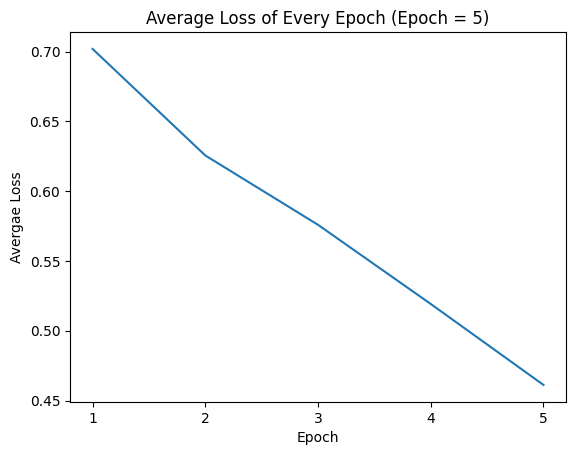

In [29]:
loss = epoch_history[::2]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, loss)
plt.title("Average Loss of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Avergae Loss")
plt.show()

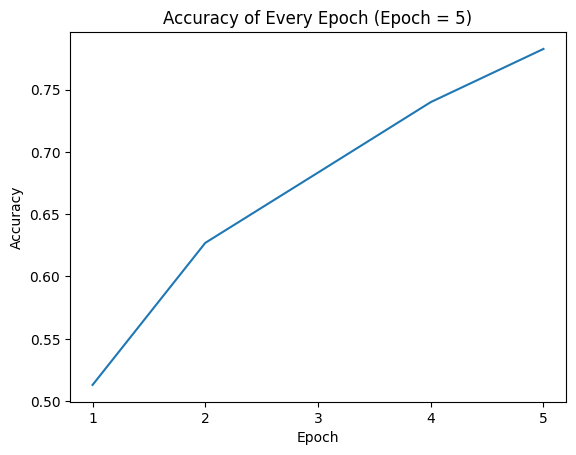

In [30]:
accuracies = [float(acc) for acc in epoch_history[1::2]]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, accuracies)
plt.title("Accuracy of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Accuracy")
plt.show()

In [32]:
model = AlexNet()
model.load_state_dict(torch.load('AlexNet_train_model.pth'))
model.eval()

test_acc = []
test_correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in tqdm(test_loader):
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

accuracy = 100*test_correct / total
print('Accuracy: {:.2f}%' .format(accuracy))

100%|██████████| 79/79 [00:35<00:00,  2.24it/s]

Accuracy: 79.68%


### ReSNet

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# stride = 1(Default)
class ReSNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ReSNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [32, 224, 224]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [64, 112, 112]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # [64, 56, 56]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        # [64, 28, 28]
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epoch_history = []

# AlexNet Model (classification of 2 classes)
model = ReSNet(num_classes=2)

# Loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = []
    train_accs = []
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.detach().cpu().item())
        train_accs.append(acc.cpu())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    epoch_history.append(train_loss)
    epoch_history.append(train_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, loss = {train_loss:.5f}, acc = {train_acc:.5f}')

torch.save(model.state_dict(), "resnet_train_model.pth")

  0%|          | 0/313 [00:00<?, ?it/s]/home/yuu0223/DeepLearning/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11030). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [04:43<00:00,  1.11it/s]


Epoch 1/5, loss = 0.69848, acc = 0.53240


100%|██████████| 313/313 [04:27<00:00,  1.17it/s]


Epoch 2/5, loss = 0.63617, acc = 0.64053


100%|██████████| 313/313 [05:03<00:00,  1.03it/s]


Epoch 3/5, loss = 0.54367, acc = 0.72534


100%|██████████| 313/313 [04:54<00:00,  1.06it/s]


Epoch 4/5, loss = 0.47746, acc = 0.77351


100%|██████████| 313/313 [05:03<00:00,  1.03it/s]

Epoch 5/5, loss = 0.42095, acc = 0.80546


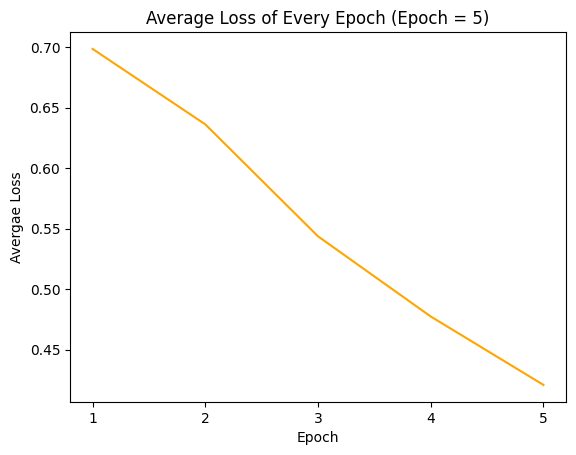

In [ ]:
loss = epoch_history[::2]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, loss, color = "orange")
plt.title("Average Loss of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Avergae Loss")
plt.show()

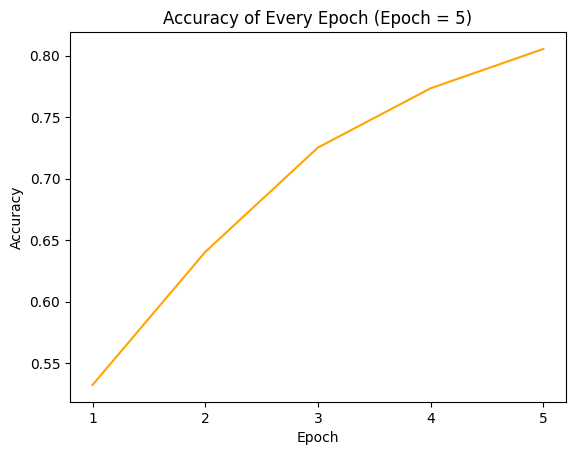

In [ ]:
accuracies = [float(acc) for acc in epoch_history[1::2]]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, accuracies, color = "orange")
plt.title("Accuracy of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Accuracy")
plt.show()

In [ ]:
model = ReSNet()
model.load_state_dict(torch.load('resnet_train_model.pth'))
model.eval()

test_acc = []
test_correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in tqdm(test_loader):
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

accuracy = 100*test_correct / total
print('Accuracy: {:.2f}%' .format(accuracy))

  0%|          | 0/79 [00:00<?, ?it/s]100%|██████████| 79/79 [00:32<00:00,  2.47it/s]

Accuracy: 80.14%


# Q2 - MINST
Follow the format of Question 1 and utilize the training data to train two different models, including VGG and a CNN model you designed. After training, assess the performance of both models using the test data. Report the accuracy of the results obtained from testing. Additionally, please provide visualizations of the training loss changes for both models.

In [2]:
train_set = datasets.MNIST(root='./mnist_data', download=True, train=True, transform=transforms.ToTensor())
test_set = datasets.MNIST(root='./mnist_data', download=True, train=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print(f'train set of {len(train_set)} samples')
print(f'test set of {len(test_set)} samples')

train set of 60000 samples
test set of 10000 samples


In [ ]:
# class MNSITDataset(Dataset):
#     def __intit__(self, data_file, label_file, transform=None):
#         self.transform = transform

#         # 讀取圖像
#         with gzip.open(data_file, 'rb') as f:
#             self.images = np.frombuffer(f.read(), np.unit8, offset=16). reshape(-1, 28, 28)

#         # 讀取標籤
#         with gzip.open(label_file, 'rb') as f:
#             self.labels = np.frombuffer(f.read(), np.unit8, offset=8)

#     # 查看照片總張數
#     def __len__(self):
#         return len(self.images)
    
#     def __getitem__(self, idx):
#         image = self.images[idx]
#         label = self.labels[idx]

#         image = np.reshape(image, (28,28)) #Original
#         image = np.resize(image, (224,224)) #After

#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

### CNN

In [62]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# stride = 1(Default)
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [32, 28, 28]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [64, 14, 14]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [128, 7, 7]
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [63]:
epoch_history = []

# AlexNet Model (classification of 10 classes)
model = CNN(num_classes=10)

# Loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = []
    train_accs = []
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.detach().cpu().item())
        train_accs.append(acc.cpu())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    epoch_history.append(train_loss)
    epoch_history.append(train_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, loss = {train_loss:.5f}, acc = {train_acc:.5f}')

torch.save(model.state_dict(), "CNN_train_model.pth")

100%|██████████| 469/469 [00:18<00:00, 25.40it/s]


Epoch 1/5, loss = 0.27422, acc = 0.91356


100%|██████████| 469/469 [00:19<00:00, 23.48it/s]


Epoch 2/5, loss = 0.09155, acc = 0.97281


100%|██████████| 469/469 [00:18<00:00, 25.16it/s]


Epoch 3/5, loss = 0.06744, acc = 0.98005


100%|██████████| 469/469 [00:18<00:00, 25.26it/s]


Epoch 4/5, loss = 0.05584, acc = 0.98383


100%|██████████| 469/469 [00:18<00:00, 25.71it/s]

Epoch 5/5, loss = 0.04862, acc = 0.98534


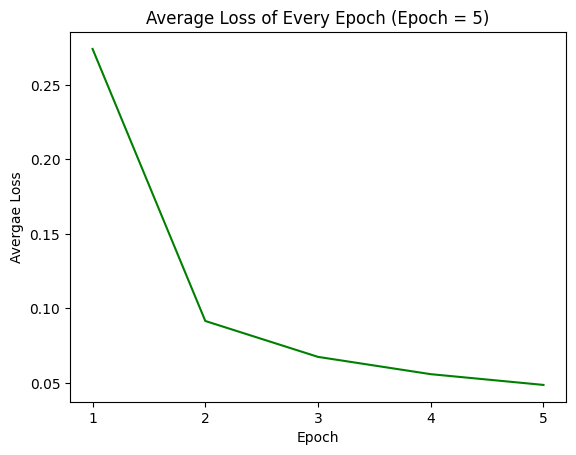

In [64]:
loss = epoch_history[::2]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, loss, color = "green")
plt.title("Average Loss of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Avergae Loss")
plt.show()

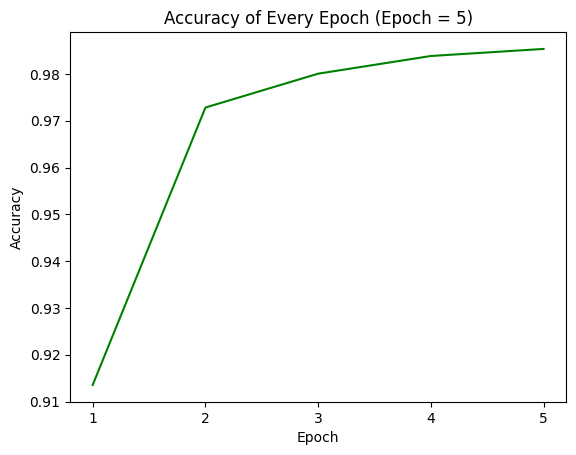

In [65]:
accuracies = [float(acc) for acc in epoch_history[1::2]]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, accuracies, color = "green")
plt.title("Accuracy of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Accuracy")
plt.show()

In [66]:
model = CNN(num_classes=10)
model.load_state_dict(torch.load('CNN_train_model.pth'))
model.eval()

test_acc = []
test_correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in tqdm(test_loader):
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

accuracy = 100*test_correct / total
print('Accuracy: {:.2f}%' .format(accuracy))

  0%|          | 0/79 [00:00<?, ?it/s]100%|██████████| 79/79 [00:01<00:00, 58.31it/s]

Accuracy: 99.30%


### VGG

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# stride = 1(Default)
class VGG(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [32, 28, 28]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [64, 14, 14]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [128, 7, 7]
            nn.ReLU(inplace=True),
        )

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(128 *7 *7 , 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
epoch_history = []

# AlexNet Model (classification of 10 classes)
model = VGG(num_classes=10)

# Loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = []
    train_accs = []
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_loss.append(loss.detach().cpu().item())
        train_accs.append(acc.cpu())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    epoch_history.append(train_loss)
    epoch_history.append(train_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, loss = {train_loss:.5f}, acc = {train_acc:.5f}')

torch.save(model.state_dict(), "VGG_train_model.pth")

  0%|          | 0/469 [00:00<?, ?it/s]/home/yuu0223/DeepLearning/venv/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11030). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 469/469 [00:16<00:00, 28.51it/s]


Epoch 1/5, loss = 0.28156, acc = 0.91060


100%|██████████| 469/469 [00:16<00:00, 29.17it/s]


Epoch 2/5, loss = 0.08990, acc = 0.97325


100%|██████████| 469/469 [00:15<00:00, 29.64it/s]


Epoch 3/5, loss = 0.06463, acc = 0.98006


100%|██████████| 469/469 [00:15<00:00, 29.47it/s]


Epoch 4/5, loss = 0.05383, acc = 0.98374


100%|██████████| 469/469 [00:16<00:00, 29.27it/s]

Epoch 5/5, loss = 0.04835, acc = 0.98540


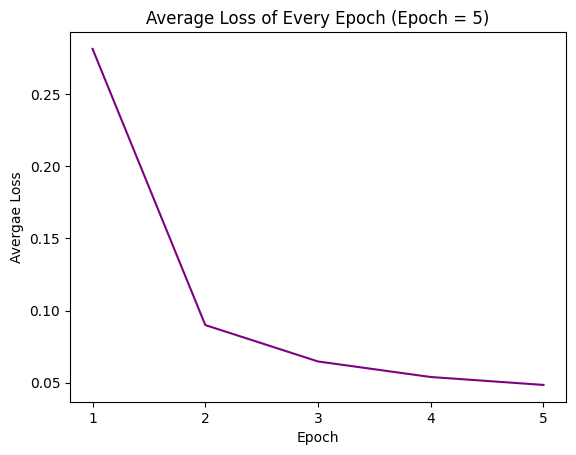

In [11]:
loss = epoch_history[::2]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, loss, color = "purple")
plt.title("Average Loss of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Avergae Loss")
plt.show()

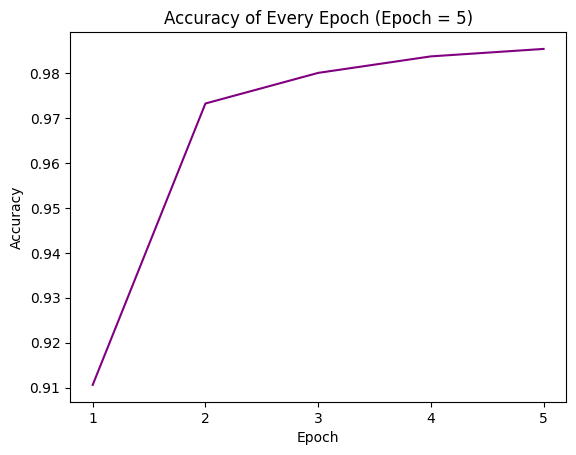

In [12]:
accuracies = [float(acc) for acc in epoch_history[1::2]]
epochs = list(range(1, len(loss) + 1))

plt.plot(epochs, accuracies, color = "purple")
plt.title("Accuracy of Every Epoch (Epoch = 5)")
plt.xlabel("Epoch")
plt.xticks([1,2,3,4,5])
plt.ylabel("Accuracy")
plt.show()

In [13]:
model = VGG(num_classes=10)
model.load_state_dict(torch.load('VGG_train_model.pth'))
model.eval()

test_acc = []
test_correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in tqdm(test_loader):
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

accuracy = 100*test_correct / total
print('Accuracy: {:.2f}%' .format(accuracy))

100%|██████████| 79/79 [00:01<00:00, 52.52it/s]

Accuracy: 99.18%
